In [ ]:
%load_ext autoreload
%autoreload 2

In [323]:
import matplotlib.rcsetup as rcsetup

print(rcsetup.interactive_bk)
print(rcsetup.non_interactive_bk)
print(rcsetup.all_backends)

['GTK3Agg', 'GTK3Cairo', 'MacOSX', 'nbAgg', 'Qt4Agg', 'Qt4Cairo', 'Qt5Agg', 'Qt5Cairo', 'TkAgg', 'TkCairo', 'WebAgg', 'WX', 'WXAgg', 'WXCairo']
['agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template']
['GTK3Agg', 'GTK3Cairo', 'MacOSX', 'nbAgg', 'Qt4Agg', 'Qt4Cairo', 'Qt5Agg', 'Qt5Cairo', 'TkAgg', 'TkCairo', 'WebAgg', 'WX', 'WXAgg', 'WXCairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template']


In [327]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import pickle
from math import exp

%matplotlib inline
np.seterr(all='warn')

mpl.rcParams['figure.dpi'] = 100

textwidth = 7.2
default_figargs = dict(figsize = (textwidth,4.45))

from montecarlo import *

In [55]:
parameters = dict(
J = 1,
U = 1,
t = 1,
mu = 0,
beta = 1,
N = 2000,
alpha = 1.5,
normalise = True,
)

parameters['J_matrix'] = interaction_matrix(**parameters)

#plot a A(omega) for U = 0
state = np.zeros(parameters['N'])
Ff, Fc, evals, evecs = solve_H(state = state, **parameters)
evals += - parameters['U'] * np.sum(state - 1/2)/parameters['N']

###now the U = 1 perfect CDW order case
state = np.arange(parameters['N'])%2
Ff, Fc, CDW_evals, evecs = solve_H(state = state, **parameters)
CDW_evals += - parameters['U'] * np.sum(state - 1/2)/parameters['N']

###now the U = 1 perfect CDW order case with 2% of sites flipped uniformly out of order
f_electrons = np.arange(parameters['N'])%2
perturbation = np.random.choice([1,-1], size=f_electrons.shape[0], p=[0.02,0.98])
perturbed_f_electrons = (f_electrons - 1/2) * perturbation + 1/2
state = perturbed_f_electrons
Ff, Fc, pert_evals, evecs = solve_H(state = state, **parameters)
pert_evals += - parameters['U'] * np.sum(state - 1/2)/parameters['N']

In [59]:
np.savez('./pickled_data/anderson_model_dos.npz', allow_pickle = True,
         desc = 'This is data for the trio plot with anderson model DOS, perfect CDW DOS and perturbed CDW DOS',
        evals=evals, CDW_evals=CDW_evals, pert_evals=pert_evals, parameters=parameters
        )

In [65]:
locals().update(np.load('./pickled_data/anderson_model_dos.npz', allow_pickle = True))
parameters = parameters[()]

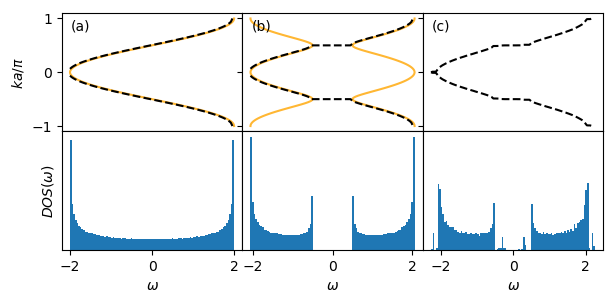

In [84]:
f, axes = plt.subplots(2,3,
                      sharey = 'row',
                      sharex = 'col',
                      figsize = (textwidth,0.5*textwidth), 
                      gridspec_kw = dict(
                         #height_ratios=[2,2,2,2,1,1,1,1],
                         #width_ratios=[2, 2],
                         wspace=0.0,
                         hspace=0.0,
                      ),
                       #**default_figargs
                     )

axes[0,0].set(
       #title = 'U/t = 0\n',
       ylabel = '$ka/\pi$',
      );

axes[0,1].set(
    #title  = 'U/t = 1\n Perfect CDW state',
)
axes[0,2].set(
    #title  = 'U/t = 1\n Dirty CDW state',
)

axes[1,0].set(
       ylabel = '$DOS(\omega)$',
      );

#add x axis labels to the bottom row
for a in axes[1]: 
    a.set(
        xlabel = '$\omega$',
        yticks = [],
    )
    

    
#add labels to the top row
for ax, label in zip(axes[0], ('(a)', '(b)', '(c)', '(d)')):
    ax.text(0.05, 0.95, label, transform=ax.transAxes, va='top', ha = 'left')    
    
analytic_kwargs = dict(color = 'orange', alpha = 0.8)
cumulative_hist_kwargs = dict(bins = 100, orientation = 'vertical', cumulative = True, histtype = 'step', density = 1, linewidth = 0)
    
#The U = 0 case
Eax, Aax = axes.T[0]

#plot a A(omega) for U = 0

normal_hist_kwargs = dict(bins = 100, orientation = 'vertical')
Aax.hist(evals, **normal_hist_kwargs);

#plot the analytic E(k) for U = 0
ka = np.linspace(-np.pi,np.pi,100)
e = -2*np.cos(ka)
Eax.plot(e, ka/np.pi, **analytic_kwargs)

#plot the cumulative histogram into the energy plot for U = 0
n, bins, _ = Eax.hist(evals, **cumulative_hist_kwargs);
Eax.plot(bins[:-1], n, '--k')
Eax.plot(bins[:-1], -n, '--k')

###now the U = 1 perfect CDW order case
Eax, Aax = axes.T[1]
Aax.hist(CDW_evals, bins = 100, orientation = 'vertical');

#plot the analytic E(k) for U = 1 CDW
U = parameters['U']
ka = np.linspace(-np.pi,np.pi,100)
e = np.sqrt(4*np.cos(ka)**2 + U**2/4)
emin = 1/2 - np.sqrt(4 + 1/4)
Eax.plot(+ e, ka/np.pi, **analytic_kwargs)
Eax.plot(- e, ka/np.pi, **analytic_kwargs)

#plot the cumulative histogram into the energy plot for U = 0 CDW
n, bins, _ = Eax.hist(CDW_evals, **cumulative_hist_kwargs);
Eax.plot(bins[:-1], n, '--k')
Eax.plot(bins[:-1], -n, '--k')

###now the U = 1 perfect CDW order case with 2% of sites flipped uniformly out of order
Eax, Aax = axes.T[2]
Aax.hist(pert_evals, bins = 100, orientation = 'vertical');

n, bins, _ = Eax.hist(pert_evals, **cumulative_hist_kwargs);
Eax.plot(bins[:-1], n, '--k')
Eax.plot(bins[:-1], -n, '--k')

f.tight_layout()
f.savefig('./figs/DOS.pdf')
f.savefig('/home/tch14/workspace/fake_home/Dropbox/Apps/Overleaf/9 Month Review/figs/DOS.pdf')

In [ ]:
f, axes = plt.subplots(6,1,
                      sharey = 'row',
                      #sharex = 'col',
                      figsize = (textwidth,textwidth), 
                      gridspec_kw = dict(
                         height_ratios=[3,3,1,1,1,1,],
                         #width_ratios=[2, 2],
                         wspace=0.3,
                         hspace=0.5,
                      )
                     )

axes[0].set(
       title  = 'U/t = 1\n Dirty CDW state',
)

axes[0].set(
       ylabel = '$A(\omega)$',
       xticks = [],
      );
axes[1].set(
       ylabel = 'IPR',
      );

#add x axis labels to the bottom row
axes[1].set(xlabel = '$\omega$')

analytic_kwargs = dict(color = 'orange', alpha = 0.8)
    

###now the U = 1 perfect CDW order case with 10% of sites flipped uniformly out of order
Nsystem = 128
Nrepeats = 100
p = 5/100
U = 1

pert_vals = np.zeros(shape = [Nsystem * Nrepeats])
pert_vecs = np.zeros(shape = [Nsystem, Nsystem * Nrepeats])
f_electrons = np.empty((Nsystem,), dtype = np.int)
f_electrons[::2] = 0
f_electrons[1::2] = 1

for i in range(Nrepeats):
    perturbation = np.random.choice([1,-1], size=f_electrons.shape[0], p=[p,1-p])

    perturbed_f_electrons = (f_electrons - 1/2) * perturbation + 1/2
    pert_vals_, pert_vecs_ = open_bc_c_electron_solver(perturbed_f_electrons, U=U)
    pert_vals_ = pert_vals_ - 1/2
    pert_vals[i*Nsystem : (i+1)*Nsystem] = pert_vals_ 
    pert_vecs[:, i*Nsystem : (i+1)*Nsystem] = pert_vecs_

n, bins, _ = axes[0].hist(pert_vals, bins = 300, orientation = 'vertical');

from scipy import fftpack
def smooth(signal, spacing, smoothing_length):
    sig_fft = fftpack.fft(signal)
    sample_freq = fftpack.fftfreq(signal.size, d=spacing)
    smoothed_fft = np.exp(-smoothing_length*np.abs(sample_freq)) * sig_fft
    return fftpack.ifft(smoothed_fft)
    
def IPR(vecs):
    return np.sum((vecs.conj()*vecs)**2, axis = 0) / np.sum((vecs.conj()*vecs), axis = 0)**2
    
smoothed = smooth(n,    
                spacing = bins[1]-bins[0],
                smoothing_length = 0.1,
                 )
    
#Aax.plot(bins[:-1], smoothed)

Aax, Iax, *Phiaxes = axes

#Plot the IPRs against energy
IPRs = IPR(pert_vecs)

#average the IPRs within each energy bin
indx = np.digitize(pert_vals, bins)
bin_averages= np.array([IPRs[indx == i].mean() for i in np.arange(len(bins))])

Iax.plot(pert_vals, IPRs, '.', markersize = 3, alpha = 0.2)
Iax.plot(bins, bin_averages, 'k')

from matplotlib.patches import Rectangle as Rect
boxes = [
    #label (energy range), (IPR range)
    ['a)', [-2.3,-2],[0.09,0.21]],
    ['b)', [-1.2,-1.17],[0,0.1]],
    ['c)', [-0.53,-0.51],[0.0,0.1]],
    ['d)', [-0.43,-0.1],[0.04,0.16]],
    #['d)', [0.1,0.43],[0.04,0.16]],
    #['e)', [1.17,1.2],[0,0.1]],
    #['f)', [2,2.4],[0.09,0.21]],
]
for ax,box in zip(Phiaxes,boxes):
    label, (Emin, Emax), (IPRmin, IPRmax) = box
    Iax.add_patch(Rect((Emin,IPRmin),
                         width = abs(Emax-Emin),
                         height = abs(IPRmax-IPRmin),
                         fill = None,
                         linestyle = '--',
                        ))
    Iax.text(Emin, IPRmax, label, horizontalAlignment = 'right')
    
    ax.set(yticks = [], xticks = [])
    ax.text(0,1,label, transform = ax.transAxes, verticalAlignment = 'top')
    
    indx = (Emin < pert_vals) & (pert_vals < Emax) & (IPRmin < IPRs) & (IPRs < IPRmax)
    assert(len(indx) > 0)
    v = pert_vecs[:, indx][:, ::30]
    if v.size > 0:
        v[abs(v) < 1e-3 * np.max(v)] = np.nan
        assert(np.isnan(v).all() == False)
        ax.plot(np.real(v))
        #ax.plot(np.imag(v))


f.savefig('./figs/states.pdf')

In [167]:
def solve(f,x):
    s = np.sign(f)
    z = np.where(s == 0)[0]
    if z.size > 0:
        return z
    else:
        s = s[0:-1] + s[1:]
        z = np.where(s == 0)[0]
        return z

def interp(f,x,z):
    m = (f[z+1] - f[z]) / (x[z+1] - x[z])
    return x[z] - f[z]/m


N_steps = 40000
N_burn_in = 5000
total_time = 29291.590218305588
(Js, Us, Ns, mc/direct, n_cumulant, beta)
(20, 3, 2, 2, 5, 20)
(Us, mc/direct, n_cumulants, Js, beta)
(3, 2, 5, 20, 20)


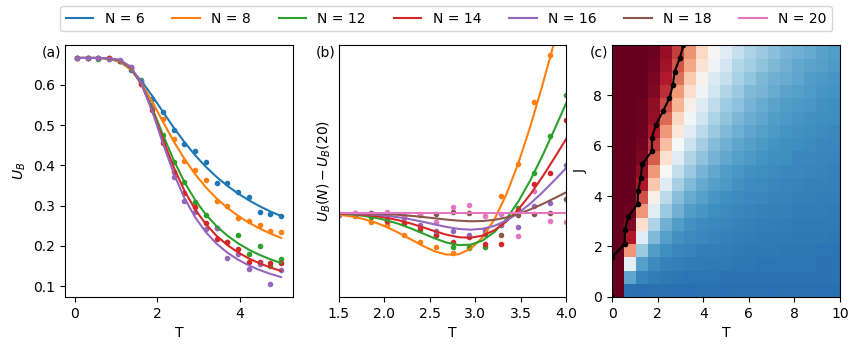

In [328]:
textwidth = 10
f, axes = plt.subplots(1,3,figsize = (textwidth,textwidth/3))

ax = axes[2]

from matplotlib.colors import Normalize
from general import *
from stats import *
#%%time

n_cumulants = 5
T = np.linspace(0.01, 10, 20)
beta = 1/T
Ns = [8,16]
Us = [0.1,1,10]
Js = np.linspace(0, 10, 20)
binder_params = dict(t = 1, alpha = 1.5, mu = 0, normalise = True)
N_steps = int(40 * 1000)
N_burn_in = int(5 * 1000)

def binder_cumulant(central_moments): return 1 - central_moments[4]/(3*central_moments[2]**2)

from itertools import count
data = np.load('./pickled_data/phase_diagram_3.npz')
locals().update(data)

for k,v in data.items():
    if k != 'mcmc_binder_cumulants': print(f'{k} = {v}')
        
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

#mcmc_binder_cumulants.shape = (Js, Us, Ns, n_cumulant)
print("(Js, Us, Ns, mc/direct, n_cumulant, beta)")
print(mcmc_binder_cumulants.shape)
i_N = 0
data = np.einsum('jumnb->umnjb', mcmc_binder_cumulants[:, :, i_N])
print("(Us, mc/direct, n_cumulants, Js, beta)")
print(data.shape)


intercept_T = np.zeros(shape = (len(Us), len(Js)))

for i, mc_slice1, J in zip(count(), mcmc_binder_cumulants, Js):
    for j, mc_slice2, U in zip(count(), mc_slice1, Us):
        
        y = binder_cumulant(mc_slice2[0,1])-binder_cumulant(mc_slice2[1,1])
        x = T
        z = solve(y, x)
        intersection = interp(y,x,z)
        y_val = np.interp(intersection, x, binder_cumulant(mc_slice2[0,1]))
        if intersection.size == 0: intersection = [np.nan,]
        
        intercept_T[j,i] = intersection[-1]

for i, U_slice, U in zip(count(), data, Us):
    if U != 1: continue
    mc_Mf_moments, mc_Mf_central_moments = U_slice

    #ax.scatter(T, binder_cumulant(mc_Mf_central_moments), marker='.')    
    #ax.plot(T, binder_cumulant(mc_Mf_central_moments), marker='.')   

    norm = Normalize(vmin=0, vmax=1)        
    cs = ax.pcolormesh(Js, T, mc_Mf_central_moments[2], cmap='RdBu_r', norm = norm)
    
    ax.plot(intercept_T[i,:], Js, color = 'k', marker = '.')
    ax.set(
        #title = f'U = {U}',
        #xlim = [0,5],
        #ylim = [0,1],
        xlabel = 'T',
        ylabel = 'J',
        yticks = [0,2,4,6,8,],
        #yscale = 'log',
        #xscale = 'log',
    )
    ax.set(ylim = (0, 10))
            
#f.legend(lines, [l.get_label() for l in lines], loc = (0.1,0.93), ncol = len(lines))
#f.suptitle('Mˆ2 phase diagram')
#f.colorbar(cs, ax=ax, orientation='vertical')

#for ax,U in zip(axes,Us): ax.set(title = f'U = {U}') 
#for ax,J in zip(axes.T, Js): ax.set(ylabel = f'J = {J}') 
#for ax in axes[-1]: ax.set(xlabel = 'T')

ax = axes[1]
from itertools import count
data = np.load('./pickled_data/binder_cumulants_direct_zoom_huge.npz')
locals().update(data)
data = np.load('./pickled_data/binder_cumulants_mcmc_zoom_3.npz')
locals().update(data)

lines = dict()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors_N = dict(zip([6,8,12,14,16,18,20], colors))

def binder_cumulant(central_moments): return 1 - central_moments[4]/(3*central_moments[2]**2)

largest_direct_bc =  binder_cumulant(binder_cumulants[0,0,-1,1])

for mc_slice1, dir_slice1, J in zip(mcmc_binder_cumulants, binder_cumulants, Js):
    for mc_slice2, dir_slice2, U in zip(mc_slice1, dir_slice1, Us):
        for i, dir_slice3, system_size in zip(count(), dir_slice2, Ns):
            dir_Mf_moments, dir_Mf_central_moments = dir_slice3
            dir_binder_cumulant = binder_cumulant(dir_Mf_central_moments)
            lines[system_size], = ax.plot(T, dir_binder_cumulant - largest_direct_bc, label = f'N = {system_size}', color = colors_N[system_size])    

        for i, mc_slice3, system_size in zip(count(), mc_slice2, mcmc_Ns):
            mc_Mf_moments, mc_Mf_central_moments = mc_slice3
            ax.scatter(1/mc_beta, binder_cumulant(mc_Mf_central_moments) - np.interp(1/mc_beta, T, largest_direct_bc), marker='.', color = colors_N[system_size])
            

ax.set(xlim = (1.5,4), ylim = (-0.02,0.04))
#ax.legend()
ax.set(ylabel = r'$U_B(N) - U_B(20)$', yticks = []) 
ax.set(xlabel = 'T')


ax = axes[0]
from itertools import count
data = np.load('./pickled_data/binder_cumulants_direct_2.npz')
locals().update(data)
data = np.load('./pickled_data/binder_cumulants_mcmc_2.npz')
locals().update(data)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


mc_slice2, dir_slice2 = mcmc_binder_cumulants[-1,-1], binder_cumulants[-1,-1]
U = Us[-1]
J = Js[-1]

for i, mc_slice3, dir_slice3, system_size in zip(count(), mc_slice2, dir_slice2, Ns):
    dir_Mf_moments, dir_Mf_central_moments = dir_slice3
    mc_Mf_moments, mc_Mf_central_moments = mc_slice3

    def binder_cumulant(central_moments): return 1 - central_moments[4]/(3*central_moments[2]**2)

    dir_binder_cumulant = binder_cumulant(dir_Mf_central_moments)
    lines[system_size], = ax.plot(T, dir_binder_cumulant, label = f'N = {system_size}', color = colors_N[system_size])    
    ax.scatter(T, binder_cumulant(mc_Mf_central_moments), marker='.', color = colors_N[system_size])    
            
#f.legend(lines, [l.get_label() for l in lines], loc = (0.1,0.93), ncol = len(lines))
#ax.legend()
ax.set(ylabel = r'$U_B$', xlabel = 'T')
#f.suptitle('Binder Cumulant against Temperature')

lines_ = np.array(list(lines.values()))[(-1,0,1,2,3,4,5),]
print(lines_)
legend = f.legend(lines_, [l.get_label() for l in lines_], loc = (0.07,0.91), ncol = len(lines_))

for ax, label in zip(axes, ('(a)', '(b)', '(c)', '(d)')):
    ax.text(-0.1, 0.999, label, transform=ax.transAxes, va='top', ha = 'left')    

#f.tight_layout()
f.savefig('/home/tch14/workspace/fake_home/Dropbox/Apps/Overleaf/9 Month Review/figs/binders.pgf');

#display(f)

Ns = [  8  16  32  64 128 256]
parameters = {'t': 1, 'alpha': 1.5, 'mu': 0, 'beta': 0.9090909090909091, 'J': 5, 'U': 5, 'normalise': True}
MCMC_params = {'N_steps': 50000, 'N_burn_in': 1000, 'logger': <montecarlo.Eigenspectrum_IPR object at 0x7f30454a8f28>, 'proposal': <function p_multi_site_poisson_reflect at 0x7f30603a12f0>, 'proposal_args': {'lam': 1}, 'accept_function': <function perturbation_accept at 0x7f30603a1598>, 'warnings': True}
time = 23274.325165510178


/workspace/tch14/conda-envs/cmth_intelpython3_2/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/workspace/tch14/conda-envs/cmth_intelpython3_2/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


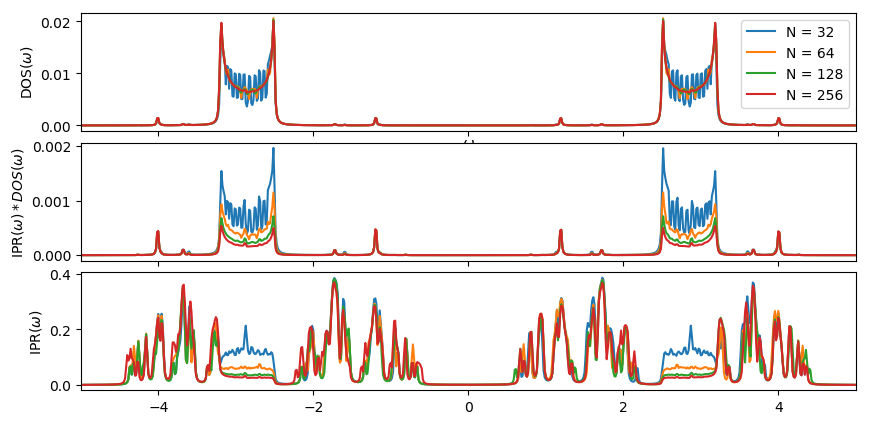

In [333]:
def plot_IPRs_2(file_name):
    p = np.load(file_name, allow_pickle = True)
    
    for k,v in p.items():
        if k != 'data': print(f'{k} = {v}')

    f, ax = plt.subplots(3,1, figsize  = (10,5), sharex = 'all', gridspec_kw = dict(hspace = 0.1, wspace = 0))
    
    for i, col, N, Nslice in zip(count(), colors, p['Ns'], p['data']):
        if N < 32: continue
        bins, E, dE, IPR, dIPR = Nslice

        IPR = IPR / N

        scale = 0.2
        pre_normed_IPR = np.where(E > 0, IPR / E, 0)

        sE = smooth(E, scale)
        sIPR = smooth(IPR, scale)

        normed_IPR = np.where(sE > 0, sIPR / sE, 0)

        ax[0].plot(bins, sE, label = f'N = {N}')
        ax[0].set(ylabel = r'DOS$(\omega)$')

        ax[1].plot(bins, sIPR)
        ax[1].set(ylabel = r'IPR$(\omega) * DOS(\omega)$')

        normed_IPR = smooth(np.where(E > 0, IPR / E, 0), scale)
        ax[2].plot(bins,  normed_IPR)
        ax[2].set(ylabel = r'IPR$(\omega)$')#, ylim = (-0.1, 20))



    ax[0].legend()
    ax[0].set(xlim = (-5, 5), xlabel = r'$\omega$')
    f.savefig('/home/tch14/workspace/fake_home/Dropbox/Apps/Overleaf/9 Month Review/figs/IPRs.pdf');
    
plot_IPRs_2('./pickled_data/IPRs_3.npz')

Ts = [ 0.1  0.5  1.   1.5  2.   2.5  3.   5.  10. ]
Ns = [  8  16  32  64 128]
parameters = {'t': 1, 'alpha': 1.5, 'mu': 0, 'beta': 0.1, 'J': 10, 'U': 10, 'normalise': True}
MCMC_params = {'N_steps': 10000, 'N_burn_in': 1000, 'logger': <montecarlo.Eigenspectrum_IPR object at 0x7f3044ac8c50>, 'proposal': <function p_multi_site_poisson_reflect at 0x7f30603a12f0>, 'proposal_args': {'lam': 1}, 'accept_function': <function perturbation_accept at 0x7f30603a1598>, 'warnings': True}
data with shape = (9, 5, 5, 1000)
time = 8356.365334033966
desc = 
        IPRS and Eigenstpectrum as a function of temp and system size
        data.shape = (betas, Ns, 5, n_bins)
        


/workspace/tch14/conda-envs/cmth_intelpython3_2/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


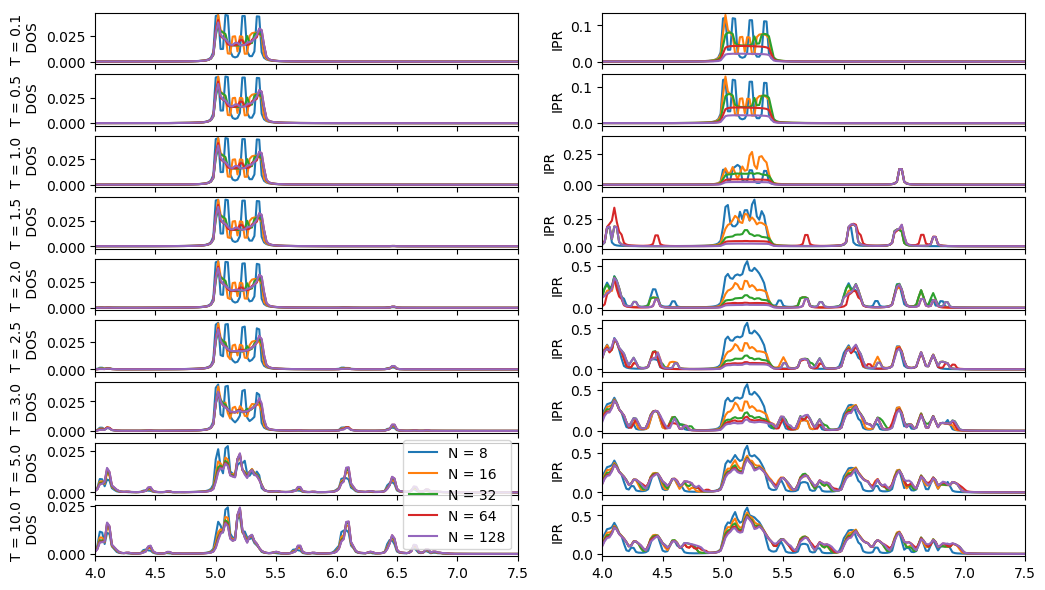

In [337]:
from general import smooth
from itertools import count

def print_keys(d):
    for k,v in d.items():
        if k == 'data':  print(f'{k} with shape = {v.shape}')
        else:  print(f'{k} = {v}')

def plot_DOS_and_IPR(IPR_ax, DOS_ax, data, label, scale = 0.1):
    bins, E, dE, IPR, dIPR = data
    IPR = IPR / N
    DOS_ax.plot(bins, smooth(E, scale), label = label)
    IPR_ax.plot(bins,  smooth(np.where(E > 0, IPR / E, 0), scale), label = label)

filename = './pickled_data/beta_IPRs_2.npz'    
p = np.load(filename, allow_pickle = True)
print_keys(p)

f, axes = plt.subplots(len(p['Ts']),2, figsize  = (12,7.2), sharex = 'all')

for (DOS_ax, IPR_ax), T, betaslice in zip(axes, p['Ts'], p['data']):
    for i, col, N, Nslice in zip(count(), colors, p['Ns'], betaslice):
        plot_DOS_and_IPR(IPR_ax, DOS_ax, data = Nslice, label = f'N = {N}', scale = 0.1)
        DOS_ax.set(ylabel = f'T = {T}\n DOS')
        IPR_ax.set(ylabel = f'IPR', xlim= (4, 7.5))
        
    
axes[-1, 0].legend()